Nama : Wilianto, S.T., S.Pd., M.M., M.T.I.

**Proyek Machine Learning untuk Pemula**

In [20]:
# Instalasi untuk folder pemisahan
!pip install split-folders
!pip install split-folders tqdm

In [21]:
# Mengimpor semua library yang dibutuhkan
import urllib.request
import zipfile, os
import splitfolders
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
# Mengunduh file dataset yang dibutuhkan
urllib.request.urlretrieve('https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip', 'rockpaperscissors.zip')

('rockpaperscissors.zip', <http.client.HTTPMessage at 0x7f9101797850>)

In [23]:
# Membaca dan mengekstraksi file dataset
local_zip = 'rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [24]:
# Penggunaan Callback mencegah overfitting dan menghentikan training setelah akurasi terpenuhi
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.97):
      print("\nAkurasi di atas 97%, hentikan training!")
      self.model.stop_training = True

callbacks = myCallback()

In [25]:
# Memisahkan dataset train 60% dan validation data 40%
splitfolders.ratio('/content/rockpaperscissors/rps-cv-images', output="/content/rockpaperscissors/output_result", ratio=(.6, .4))

Copying files: 2188 files [00:00, 3084.18 files/s]


In [26]:
# Mendefinisikan lokasi folder
base_dir = '/content/rockpaperscissors/output_result'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [27]:
# Menunjukkan folder val list
os.listdir('/content/rockpaperscissors/output_result/val')

['paper', 'rock', 'scissors']

In [28]:
# Mendefinisikan fungsi untuk membaca list name dari file
def read_list(directory):
  list_label = []
  list_file = []
  for label in os.listdir(directory):
    for item in os.listdir(os.path.join(directory, label)):
      list_label.append(label)
      list_file.append(os.path.join(directory, label, item))
  return pd.DataFrame({'labels': list_label, 'filepath':list_file})

In [29]:
train_df = read_list(train_dir)
validation_df = read_list(validation_dir)

In [30]:
pd.set_option('display.max_colwidth', -1)
train_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,labels,filepath
0,paper,/content/rockpaperscissors/output_result/train/paper/yfoLtt4c7Rzc5VOW.png
1,paper,/content/rockpaperscissors/output_result/train/paper/QWT9FOhLABPyKIUA.png
2,paper,/content/rockpaperscissors/output_result/train/paper/Z9vSGzBQ8YLOXQIX.png
3,paper,/content/rockpaperscissors/output_result/train/paper/aKUFn8PEF7LP8BaX.png
4,paper,/content/rockpaperscissors/output_result/train/paper/KSueOZE0QWbJClvK.png
...,...,...
1307,scissors,/content/rockpaperscissors/output_result/train/scissors/NeYB1usFd9o84q13.png
1308,scissors,/content/rockpaperscissors/output_result/train/scissors/BpCDUnGgYRS4T8IG.png
1309,scissors,/content/rockpaperscissors/output_result/train/scissors/F4iIoT06hTWSuSs2.png
1310,scissors,/content/rockpaperscissors/output_result/train/scissors/TNOQ2IEy4C6LBSD1.png


In [31]:
# Mengatur image data generator
data_train_img_gen = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
  )

data_val_img_gen = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
  )

In [32]:
# Membuat train generator
train_generator = data_train_img_gen.flow_from_dataframe(
    train_df,
    class_mode='categorical',
    x_col='filepath',
    y_col='labels',
    target_size=(150,150),
    batch_size=32
)

val_generator = data_val_img_gen.flow_from_dataframe(
    validation_df,
    class_mode='categorical',
    x_col='filepath',
    y_col='labels',
    target_size=(150,150),
    batch_size=32
)

Found 1312 validated image filenames belonging to 3 classes.
Found 876 validated image filenames belonging to 3 classes.


In [33]:
# Membuat model dan melakukan training
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2, 2))
Conv2D(64, (3,3), activation='relu'),
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Melihat ringkasan model
model.summary()

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(),
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    steps_per_epoch = 41, # 1312 images = batch_size * steps
    epochs = 20,
    validation_data = val_generator,
    validation_steps = 27, # 876 images = batch_size * steps
    verbose =2,
      callbacks=[callbacks]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 35, 35, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 64)       0         
 2D)                                                             
                                                      

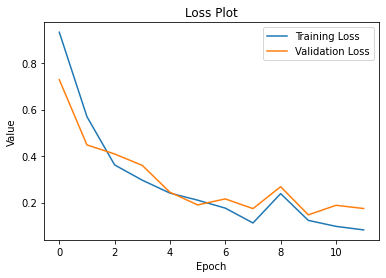

In [34]:
from matplotlib import pyplot as plt
#loss train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

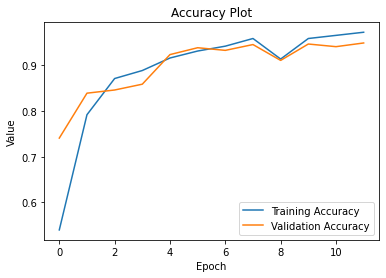

In [35]:
#accuracy train & validation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

In [36]:
# Membuat definisi untuk memeriksa hasil
def check_result(classes):
  classes = np.argmax(classes)
  if classes == 0:
    print('paper')
  elif classes == 1:
    print('rock')
  else:
    print('scissors')

Saving Shape3.png to Shape3 (1).png
Shape3.png
scissors


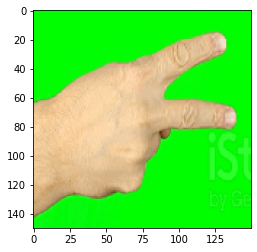

In [37]:
# Membuat fungsi untuk mengupload file dan melakukan prediksi
uploaded = files.upload()
def check_uploaded_image():
  for fn in uploaded.keys():
    path = fn
    img = image.load_img(fn, target_size=(150,150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(fn)
    check_result(classes)

check_uploaded_image()